In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip


# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format


In [2]:
import initial_condition
from analysis import weight
from analysis import rank as vr


In [4]:
global data_dir, output_dir
data_dir = '../../data/processed/internal/technology/'
output_dir = '../../output/'


In [5]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT
applicant_weight = initial_condition.APPLICANT_WEIGHT

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM


In [6]:
df = pd.read_csv(f'{data_dir}{ar}_{year_style}_{top_p_or_num[0]}_{top_p_or_num[1]}.csv')
df

,app_year_period,schmoch35,reg_num,right_person_name,ubiquity,tci,ki_1,ki_2,ki_3,ki_4,...,ki_11,ki_12,ki_13,ki_14,ki_15,ki_16,ki_17,ki_18,ki_19,ki_20
0,1981-1990,1,48775,477,118,-1.121,6.695,120.598,7.093,122.545,...,7.423,125.989,7.439,126.213,7.447,126.346,7.452,126.424,7.455,126.469
1,1981-1990,2,50732,408,81,-2.276,6.358,101.657,6.933,113.578,...,7.397,125.336,7.422,125.855,7.438,126.147,7.447,126.312,7.452,126.406
2,1981-1990,3,22941,277,73,-2.817,6.589,97.554,6.944,111.138,...,7.382,125.088,7.414,125.713,7.432,126.064,7.444,126.264,7.450,126.378
3,1981-1990,4,4090,135,52,-3.204,7.135,92.935,6.973,109.148,...,7.372,124.901,7.408,125.606,7.429,126.004,7.441,126.229,7.449,126.358
4,1981-1990,5,11636,215,77,-2.926,6.675,97.499,6.934,110.655,...,7.380,125.029,7.412,125.679,7.432,126.046,7.443,126.254,7.450,126.372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2001-2010,31,27100,462,125,0.252,6.912,125.841,7.245,125.305,...,7.616,122.847,7.626,122.771,7.631,122.737,7.633,122.722,7.634,122.715
136,2001-2010,32,53960,340,99,0.021,5.939,124.112,7.042,124.842,...,7.610,122.807,7.623,122.748,7.629,122.724,7.632,122.714,7.633,122.711
137,2001-2010,33,51674,350,67,-1.156,4.164,93.915,5.931,109.226,...,7.541,122.079,7.589,122.408,7.612,122.563,7.624,122.637,7.629,122.673
138,2001-2010,34,13886,362,84,-0.062,7.071,112.042,7.349,119.192,...,7.621,122.605,7.628,122.661,7.631,122.686,7.633,122.698,7.634,122.703


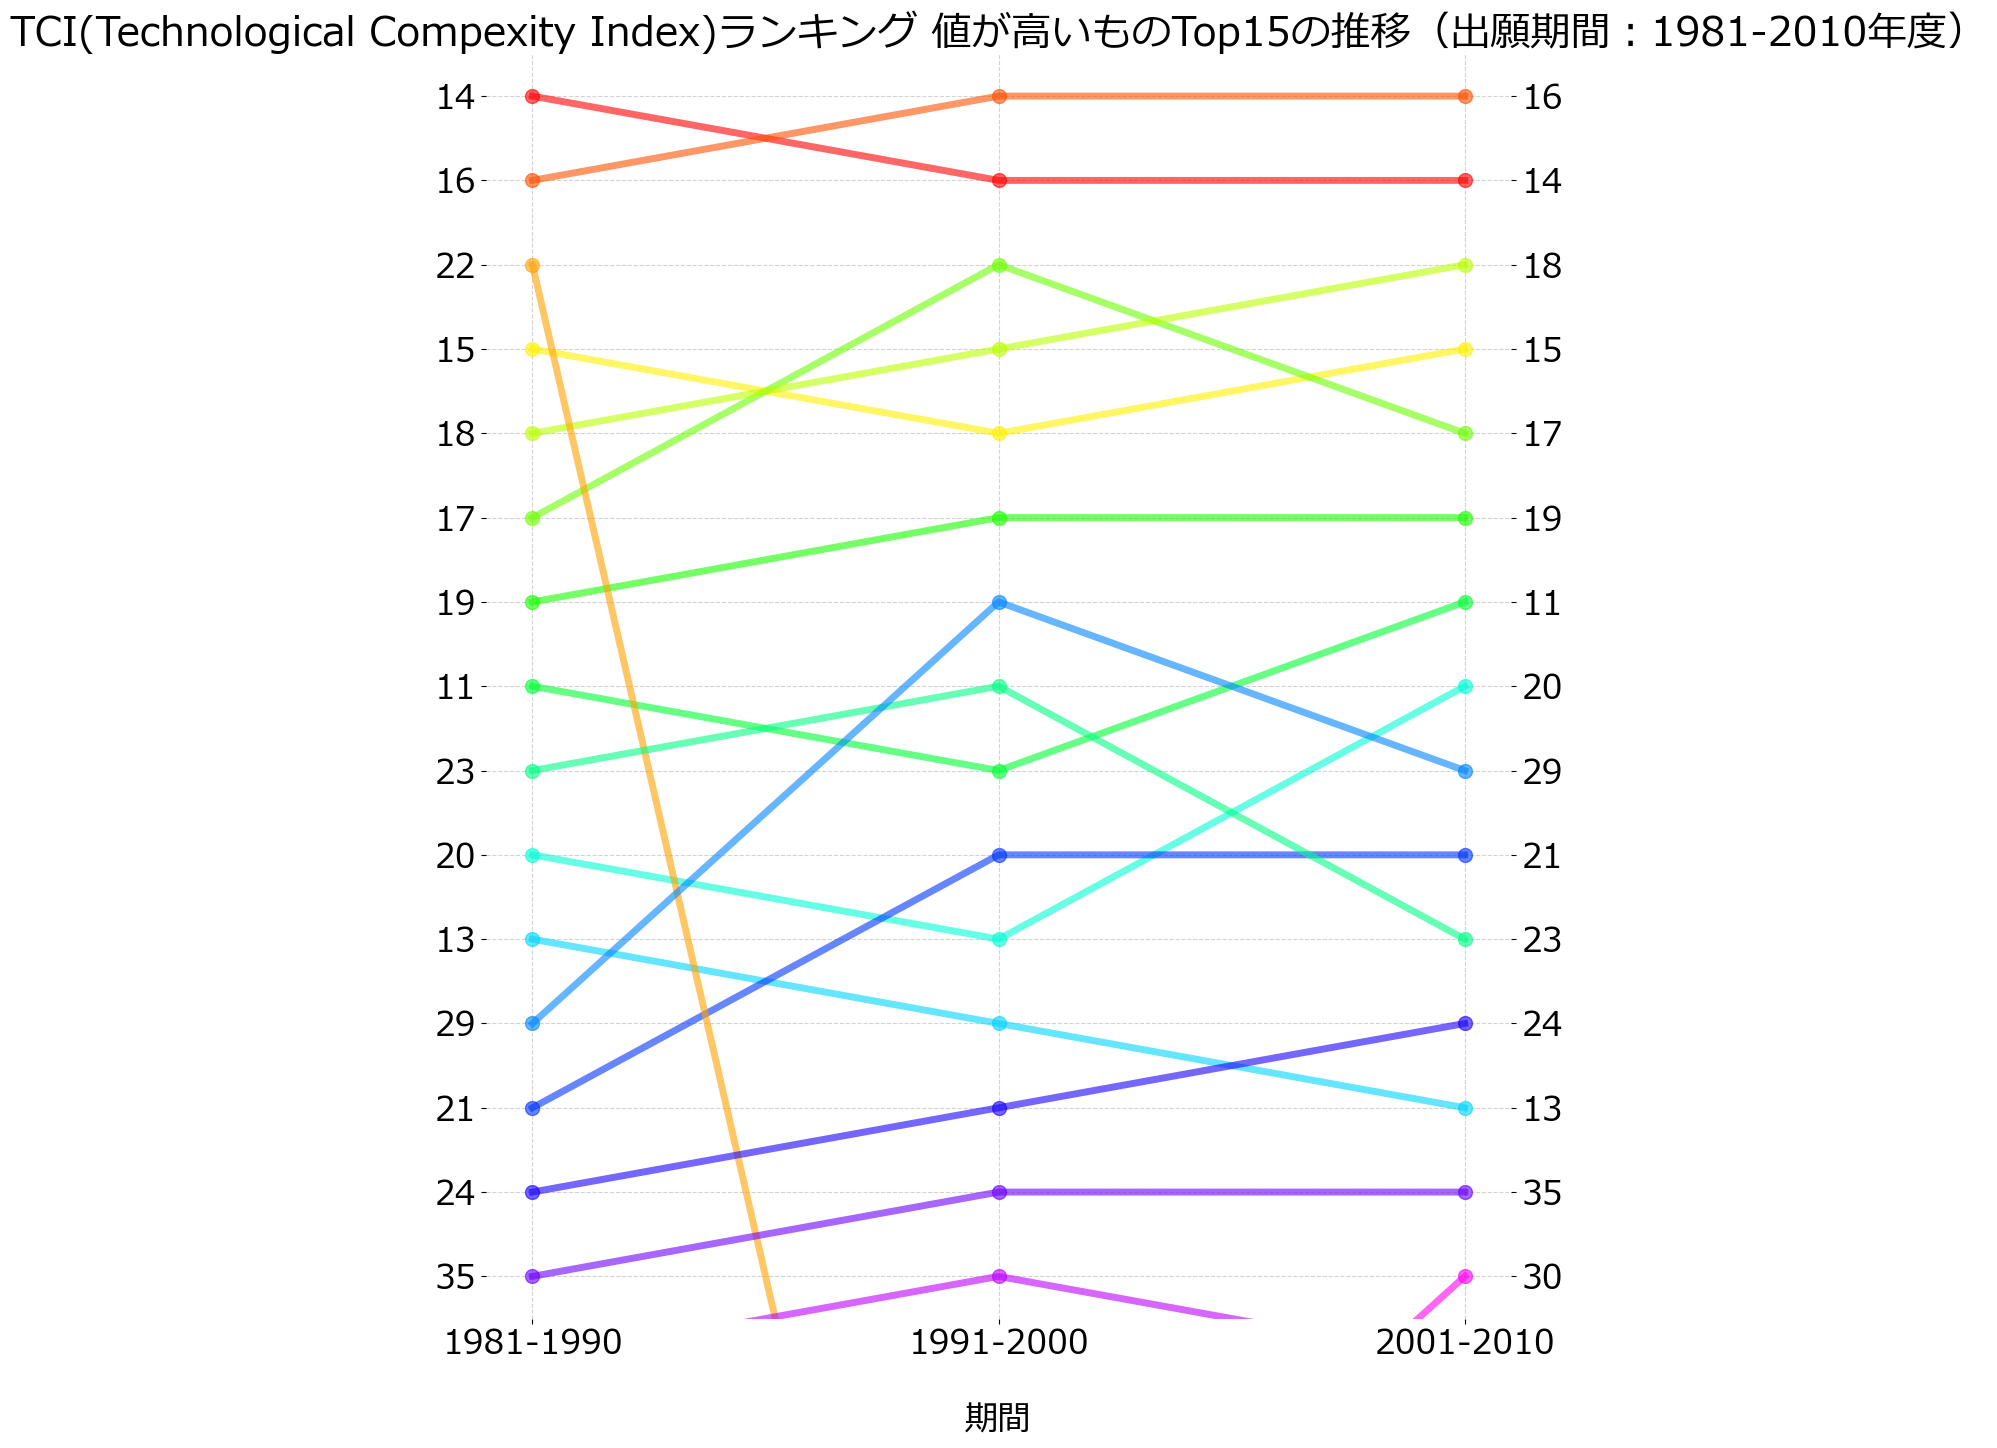

In [7]:
df_dict = {}
combi_dict = {# 1: ['right_person_name', 'diversity', f'特許権者次数(=diversity，k_h0)ランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 1: ['right_person_name', '', f'特許権者次数(=diversity，k_h0)ランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 2: ['right_person_name', 'diversity', f'特許権者次数(=diversity，k_h0)ランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
            #   3: ['right_person_name', 'eci', f'KCIランキング 値が小さいものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 3: ['right_person_name', 'ipc_class_num', f'IPC数ランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 4: ['right_person_name', 'kci', f'KCIランキング 値が大きいものTop15の推移（出願期間：{year_start}-{year_end}年度）', False], 
              # 5: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 低次数Top15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              # 6: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 高次数Top15の推移（出願期間：{year_start}-{year_end}年度）', False], 
            #   7: ['ipc_class', 'pci', f'TCI(Technological Compexity Index)ランキング 値が低いものTop15の推移（出願期間：{year_start}-{year_end}年度）', True], 
              8: [classification, 'tci', f'TCI(Technological Compexity Index)ランキング 値が高いものTop15の推移（出願期間：{year_start}-{year_end}年度）', False]
              }



for i, combi in combi_dict.items():
    div_df = df[[f'{ar}_{year_style}_period']+combi[:1+1]].sort_values(by=[f'{ar}_{year_style}_period', combi[1]], ascending=[True, False]).copy()
    div_df = div_df.drop_duplicates(keep='first')
    div_df_dict = {}
    for year in range(year_start, year_end+1, year_range):
        period = f'{year}-{year+year_range-1}'
        div_df_dict[period] = div_df[div_df[f'{ar}_{year_style}_period']==period].copy()
        # display(div_df_dict[f'{year}-{year+year_range-1}'].head(15))
    if i==4:
        df['kci_rank'] = df.groupby(f'{ar}_{year_style}_period')[['kci']].rank(ascending=False, method='first').reset_index(drop=False)['kci']
        # display(c_df[c_df['right_person_name'].str.contains('三菱重工業')])
    if i > 4: fs = (12, 15)
    else: fs = (10, 12)
    # display(div_df)
    sample = vr.rank_doubleaxis(div_df_dict, 
                version='kci', 
                    rank_num=15,
                    member_col=combi[0], 
                    num_col=combi[1],
                    prop_dict={
                        'figsize': fs,
                        'xlabel': '期間',
                        'ylabel': '',
                        'title': combi[2],
                        'fontsize': 24, 
                        'year_range': year_range, 
                        'ascending': combi[3], 
                        # 'color': color_dict
                        'color': 'default'
                    })
    # plt.savefig(f'../Fig/Rank/p{p}/{combi[2]}{year_range}年ごと.png')
    plt.show()
